# 1. Introduction
Our task is **salary classification** based on various aspects such as education, age, martial-status and others.
Because our dataset contains labeled targets, this is **supervised learning problem**, specifically **binary classification** task.
The overall goal is to:
* understand and explore the data,
* preprocess and aggregate if necesarry,
* compare the performance of different models,
* and, finally predicting wheter income is **less than 50k** or **greater thank 50k**



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/salary-prediction-classification/salary.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

# 2. Load the data

In [3]:
df = pd.read_csv("../input/salary-prediction-classification/salary.csv", skipinitialspace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df.shape

(32561, 15)

In [5]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

# 3. Exploratory Data Analysis
Exploratory Data Analysis (EDA) is the process of exploring and understanding a dataset before building any models.  
It involves using **basic statistics** and **visualizations** to discover patterns, detect anomalies, test hypotheses, and check assumptions.  
Through EDA we can gain valuable insights that guide data preprocessing, feature engineering,

Q1. Does the older get more money?

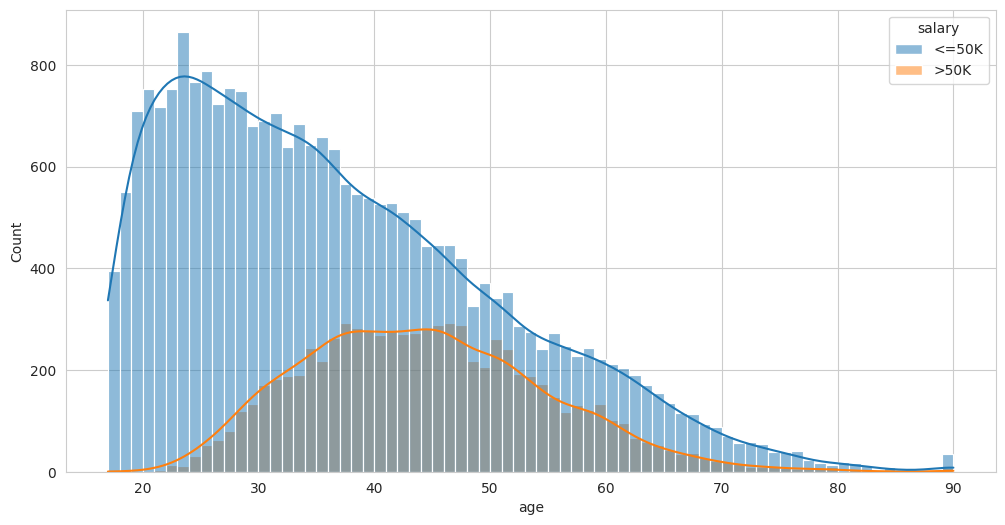

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(
    data = df,
    x = 'age', 
    binwidth=1,
    hue = 'salary',
    kde=True,
)
plt.show()

We can observe that people in their early twenties are more likely to earn less than 50K, which is expected as most of them are at the beginning of their careers.  
As age increases, the proportion of individuals earning more than 50K gradually rises, while the curve for <=50K decreases.  
The distribution of higher salaries peaks around the forties, after which both groups show a decline with age.

Related questions ?
1. What are the jobs of those who are 21 years old or less and making more than 50k?
2. Which occupations dominate among people in their 40s, when the >50k reaches its peak?

In [7]:
df_young = df[(df['age'] <= 20) & (df['salary'] == '>50K')]
df_young

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
7741,19,Private,323605,7th-8th,4,Never-married,Other-service,Not-in-family,White,Male,0,0,60,United-States,>50K
22910,19,?,200790,12th,8,Married-civ-spouse,?,Other-relative,White,Female,15024,0,40,United-States,>50K


As we can see we have missing values. They didn't pop up at the start because of the way they were written down in the dataset - "?"

* The output appears to be noise — there are only two records that are highly unusual and do not provide meaningful information.  
We will treat them as outliers and after spliting the data we shall remove them from the dataset.


In [8]:
df.replace('?', np.nan, inplace=True)
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
salary               0
dtype: int64

In [9]:
df['occupation'].fillna('Other-service', inplace=True)
df['workclass'].fillna('Other', inplace=True)
df['native-country'].fillna('Other', inplace=True)

In [10]:
forties_over50k = df[(df['age'].between(40,49)) & (df['salary']=='>50K')]
top_occupation = forties_over50k['occupation'].value_counts().head(10)
print(top_occupation)

occupation
Exec-managerial      697
Prof-specialty       668
Craft-repair         313
Sales                312
Adm-clerical         185
Tech-support          99
Transport-moving      99
Machine-op-inspct     88
Protective-serv       67
Other-service         67
Name: count, dtype: int64


* The analysis shows that among individuals aged 40–49 who earn more than 50K, the most common occupations are **Executive/Managerial** and **Professional specialties**, followed by **Craft-repair** and **Sales**.  
This suggests that higher income in the forties is strongly associated with leadership, specialized professional roles, and skilled technical jobs.  
Clerical, support, and service-related occupations also appear, but with much lower counts, indicating they are less likely to be linked with higher salaries in this age group.


Q2. Is education correlated to salary?

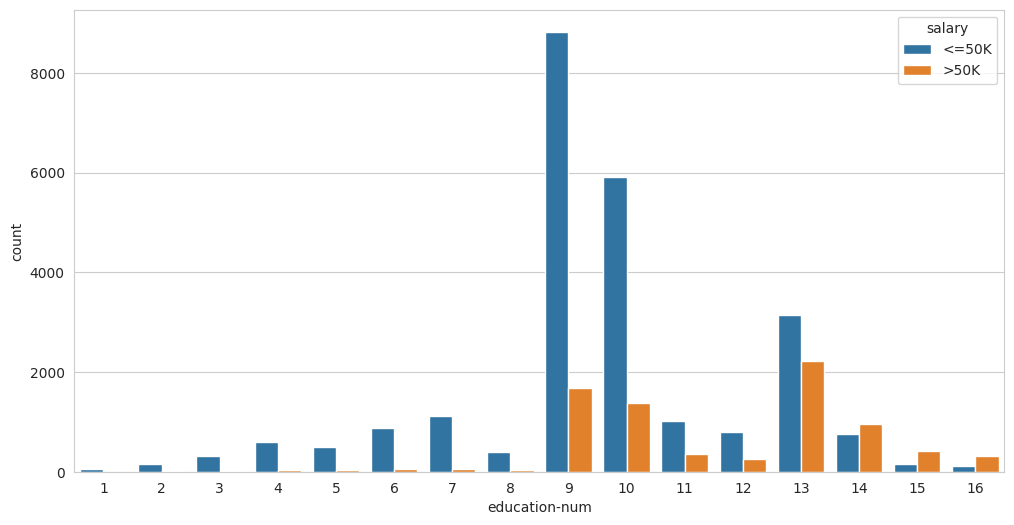

In [11]:
plt.figure(figsize=(12,6))
sns.countplot(df, x='education-num', hue='salary')
plt.show()

In [12]:
df.groupby('salary')['education-num'].mean()

salary
<=50K     9.595065
>50K     11.611657
Name: education-num, dtype: float64

In [13]:
edu_counts = df.groupby(['education-num', 'salary']).size().unstack(fill_value=0)
edu_counts['share_over_50k'] = (edu_counts['>50K']  / (edu_counts['>50K'] + edu_counts['<=50K'])).round(3)
edu_counts_sorted = edu_counts.sort_values('share_over_50k', ascending=False)

print(edu_counts_sorted[['>50K', '<=50K', 'share_over_50k']])

salary         >50K  <=50K  share_over_50k
education-num                             
16              306    107           0.741
15              423    153           0.734
14              959    764           0.557
13             2221   3134           0.415
11              361   1021           0.261
12              265    802           0.248
10             1387   5904           0.190
9              1675   8826           0.160
8                33    400           0.076
6                62    871           0.066
4                40    606           0.062
5                27    487           0.053
7                60   1115           0.051
3                16    317           0.048
2                 6    162           0.036
1                 0     51           0.000


The plot, the means, and the aggregated table show a clear relationship between education level (measured by *education-num*) and salary.  
Most individuals with lower education levels (values 9–10, corresponding to HS-grad and Some-college) are in the <=50K group.  
As education increases, the proportion of people earning >50K rises significantly — especially for *Bachelors (13)*, *Masters (14)*, *Prof-school graduates (15)*, and *Doctorate (16)*.  
This indicates that higher education is positively correlated with higher income, although even within advanced education levels there is still a notable share of <=50K earners.

Related question:
1. Which individuals earn more than 50K despite having only a primary or lower education? (below HS)

In [14]:
below_hs = df[(df['education-num']<9) & (df['salary']=='>50K')]
below_hs

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
183,40,Private,286370,7th-8th,4,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,Mexico,>50K
214,54,Self-emp-inc,125417,7th-8th,4,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
415,35,Private,92440,12th,8,Divorced,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,>50K
588,52,Private,25826,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1887,47,United-States,>50K
592,60,Private,39352,7th-8th,4,Never-married,Transport-moving,Not-in-family,White,Male,0,0,48,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31998,52,Other,89951,12th,8,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,40,United-States,>50K
32084,48,Private,105808,9th,5,Widowed,Transport-moving,Unmarried,White,Male,0,0,40,United-States,>50K
32138,50,Self-emp-inc,121441,11th,7,Never-married,Exec-managerial,Other-relative,White,Male,0,2444,40,United-States,>50K
32179,58,Private,250206,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,5178,0,40,United-States,>50K


In [15]:
print(below_hs['occupation'].value_counts().head(10))

occupation
Craft-repair         66
Transport-moving     43
Exec-managerial      26
Sales                25
Machine-op-inspct    23
Other-service        20
Handlers-cleaners    14
Farming-fishing      10
Prof-specialty        7
Adm-clerical          6
Name: count, dtype: int64


In [16]:
print(below_hs['hours-per-week'].describe())
print(df['hours-per-week'].describe())

count    244.000000
mean      45.250000
std       11.194456
min       10.000000
25%       40.000000
50%       40.000000
75%       50.000000
max       99.000000
Name: hours-per-week, dtype: float64
count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64


In [17]:
print(below_hs['capital-gain'].describe())
print(below_hs['capital-loss'].describe())

count      244.000000
mean      2866.077869
std      11471.442872
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64
count     244.000000
mean      191.344262
std       603.084919
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2824.000000
Name: capital-loss, dtype: float64


In [18]:
print(below_hs['age'].describe())

count    244.000000
mean      47.881148
std       12.320406
min       19.000000
25%       38.750000
50%       48.000000
75%       57.000000
max       83.000000
Name: age, dtype: float64


From our analysis we created a profile of individuals with lower education who still earn more than 50K.  
Almost half of them are employed in **Craft-repair** and **Transport-moving** occupations.  
They also tend to work longer hours than average and are typically around their 50s.  
A small fraction of this group (less than 25%) benefits from profitable capital investments on top of their salary.\
This shows that despite lower education, hard manual work, long hours, and sometimes capital gains can still lead to higher income

Q3. Is gender correlated to salary with respect to education?

We need to be cautious here, since simply plotting absolute counts may lead to misleading conclusions.  
The dataset itself is imbalanced — around two thirds of the individuals are male and only one third are female (as you can see below).  
If we only look at absolute values, we might wrongly assume that gender alone drives salary differences.  


In [19]:
male_ratio = (df['sex']=='Male').sum()/df.shape[0] * 100
print(f"Male to female ratio : {male_ratio:.0f}:{100 - male_ratio:.0f}")

Male to female ratio : 67:33


Instead, we need to normalize by education level and analyze proportions of >50K earners within each gender group.  
This way, demographic imbalance will not distort our interpretation.

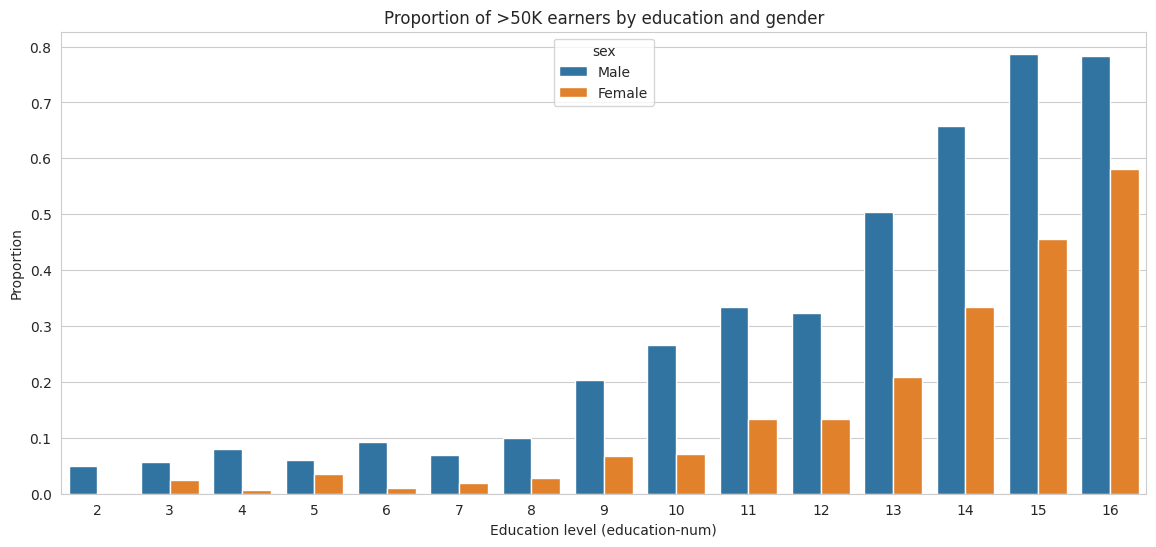

In [20]:
edu_gender_salary = (
    df.groupby(['education-num', 'sex', 'salary'])
    .size()
    .reset_index(name='count')
)
edu_gender_salary['proportion'] = (
    edu_gender_salary.groupby(['education-num', 'sex'])['count']
    .transform(lambda s: s / s.sum())
)

prop_over50 = edu_gender_salary[edu_gender_salary['salary'] == '>50K']

plt.figure(figsize=(14,6))
sns.barplot(
    data=prop_over50,
    x='education-num',
    y='proportion',
    hue='sex',
)
plt.title('Proportion of >50K earners by education and gender')
plt.xlabel('Education level (education-num)')
plt.ylabel('Proportion')
plt.show()

The chart shows that gender is correlated with earnings, but the strength of this relationship depends on education level.  
At lower education levels, the disparity is very large: men are far more likely than women to earn more than 50K.  
As education increases, the gap narrows — women benefit significantly from higher education, and their share of >50K earners grows closer to men’s levels.  
At the highest education levels (Prof-school and Doctorate), the difference is still present but noticeably smaller than at the bottom of the education scale.

Q4. Is race correlated to salary with respect to education?

Given that this dataset comes from the US in the 1990s, we can anticipate disparities across racial groups.  
However, rather than relying on assumptions, it is important to measure and visualize how strong these differences actually are, especially when controlling for education level.

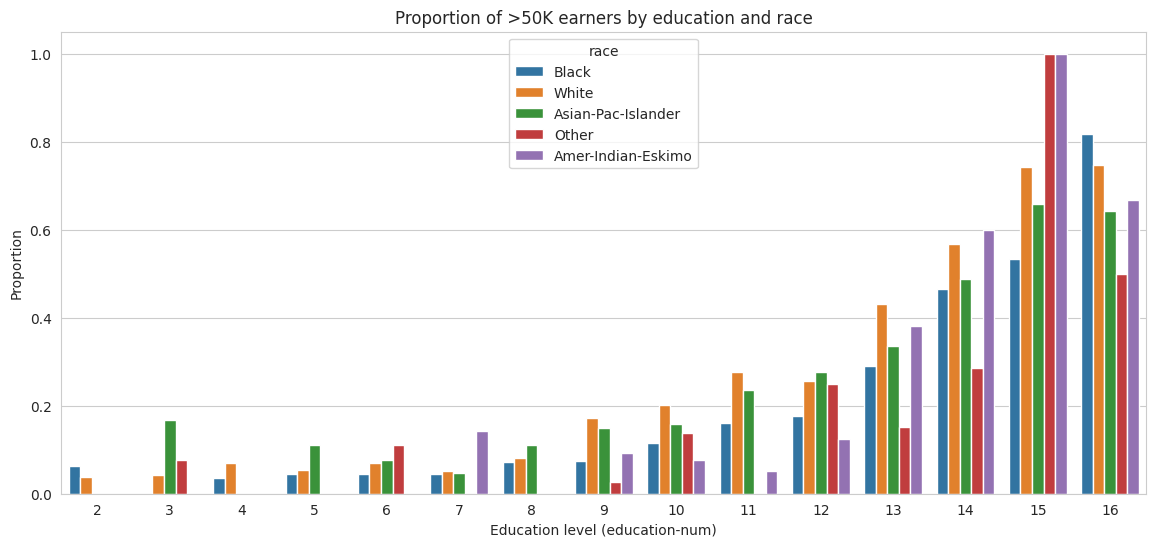

In [21]:
edu_race_salary = (
    df.groupby(['education-num', 'race', 'salary'])
    .size()
    .reset_index(name='count')
)
edu_race_salary['proportion'] = (
    edu_race_salary.groupby(['education-num', 'race'])['count']
    .transform(lambda s: s / s.sum())
)

over50 = edu_race_salary[edu_race_salary['salary'] == '>50K']

plt.figure(figsize=(14,6))
sns.barplot(
    data=over50,
    x='education-num',
    y='proportion',
    hue='race',
)
plt.title('Proportion of >50K earners by education and race')
plt.xlabel('Education level (education-num)')
plt.ylabel('Proportion')
plt.show()

The outcome is somewhat different from our initial expectations.  
As education level increases, disparities between racial groups diminish, and at the highest levels of education the proportions of >50K earners become much more similar.  
One interesting observation is that the share of Black individuals with a doctorate degree is higher compared to other races.  
There are also potential anomalies in the data: for example, in the *Other* and *Amer-Indian-Eskimo* groups at the Prof-school level, 100% of individuals earn more than 50K.  
This is most likely due to very small sample sizes, so such results should be interpreted with caution.

# 4. Data preprocessing

At this stage we move from exploratory analysis to preparing the dataset for modeling.  
This involves splitting the data into training and test sets, encoding categorical variables, and scaling numerical features where necessary.  
Proper preprocessing is crucial, since it ensures that our models will not only train effectively but also generalize well to unseen data.


In [22]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['salary', 'education'])
y = df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

Let's get rid of outliers that we got to know about in the **EDA**

In [23]:
train_df = X_train.copy()
train_df['salary'] = y_train
train_df = train_df[~((train_df['age']<=20) & (train_df['salary']=='>50K'))]
X_train = train_df.drop('salary', axis=1)
y_train = train_df['salary']

In [24]:
X_train

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
2061,20,Other,376474,10,Never-married,Other-service,Own-child,White,Male,0,0,32,United-States
26968,26,Private,120268,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,50,United-States
7201,28,Self-emp-not-inc,204984,13,Never-married,Tech-support,Not-in-family,White,Male,0,0,45,United-States
16819,35,Private,301862,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
8329,54,Private,169182,9,Separated,Adm-clerical,Unmarried,White,Female,0,0,38,Puerto-Rico
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5518,39,Local-gov,139364,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,35,United-States
30012,35,Private,108140,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
26495,39,Private,336880,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
29929,44,Private,107218,13,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,40,United-States


In [25]:
train_df['native-country'].value_counts()

native-country
United-States                 23347
Mexico                          511
Other                           459
Philippines                     163
Germany                         108
El-Salvador                      96
Puerto-Rico                      88
Canada                           87
Cuba                             81
India                            78
England                          73
Jamaica                          64
China                            63
Dominican-Republic               62
Italy                            61
South                            58
Vietnam                          56
Poland                           49
Guatemala                        49
Japan                            46
Columbia                         44
Taiwan                           40
Haiti                            32
Nicaragua                        30
Iran                             30
Peru                             27
Portugal                         25
Ecuador      

The *native-country* feature contains many unique categories, with the vast majority of records coming from the United States.  
This extreme imbalance can distort the model. Furthermore, applying One-Hot Encoding would create a high-dimensional feature space, which increases computational cost and may lead to overfitting.  

It might be tempting to use a Label Encoder, but while tree-based models can handle such integer encodings reasonably well, linear models would incorrectly assume an ordinal relationship between countries (e.g., Mexico=1, Poland=2 → interpreted as “closer”), which is not meaningful.  

To avoid both high dimensionality and false ordinality, we will apply a simple binning strategy: mapping the United States to one category (*US*) and grouping all other countries into a single category (*Non-US*).

In [26]:
def country_bucket(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if 'native-country' in X.columns:
        X['native-country'] = np.where(
            X['native-country'] == "United-States",
            'US',
            'Non-US'
        )
    return X

In [27]:
train_df['occupation'].value_counts()

occupation
Other-service        4070
Craft-repair         3280
Prof-specialty       3277
Exec-managerial      3254
Adm-clerical         3023
Sales                2948
Machine-op-inspct    1611
Transport-moving     1272
Handlers-cleaners    1104
Farming-fishing       795
Tech-support          737
Protective-serv       545
Priv-house-serv       122
Armed-Forces            8
Name: count, dtype: int64

In [28]:
train_df['workclass'].value_counts()

workclass
Private             18145
Self-emp-not-inc     2011
Local-gov            1720
Other                1447
State-gov            1050
Self-emp-inc          901
Federal-gov           755
Without-pay            12
Never-worked            5
Name: count, dtype: int64

We have some noise here that we can get rid of.

In [29]:
def collapse_fixed_categories(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    if 'occupation' in X.columns:
        X.loc[X['occupation'] == 'Armed-Forces', 'occupation'] = 'Other-service'
    if 'workclass' in X.columns:
        X.loc[X['workclass'].isin(['Without-pay', 'Never-worked']), 'workclass'] = 'Other'
    return X

Since tree-based models can benefit from engineered features such as differences and ratios, we will create additional capital features (*capital_diff* and *capital_log_ratio*).

In [30]:
def add_capital_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    gain = X.iloc[:, 0]
    loss = X.iloc[:, 1]
    out = pd.DataFrame({
        'capital-diff' : gain - loss,
        'capital-log-ratio': np.log1p(gain) - np.log1p(loss)
    })
    return out

Now let's create a preprocessing pipeline

In [31]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

num_attribs = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat_attribs = [col for col in X_train.columns if col not in num_attribs]

cat_pipe = make_pipeline(
    FunctionTransformer(country_bucket),
    FunctionTransformer(collapse_fixed_categories),
    OneHotEncoder(handle_unknown='ignore')
)
capital_pipe = make_pipeline(
    FunctionTransformer(add_capital_features),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ("cat", cat_pipe, cat_attribs),
    ("cap", capital_pipe, ['capital-gain', 'capital-loss']),
    ("num", StandardScaler(), num_attribs)
])
le = LabelEncoder()

In [32]:
X_train_enc = preprocessing.fit_transform(X_train)
X_test_enc = preprocessing.transform(X_test)
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 5. Modeling
Since our dataset is of medium size, we will benchmark several different classifiers. At this stage, we focus on baseline performance and do not fine-tune hyperparameters for each model.

In [33]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

names = [
    "Linear SVM",
    "Logistic Regression",
    "Nearest Neighbors",
    "AdaBoost",
    "Random Forest",
    "Gradient Boost",
    "HGB",
    "XGB"
]

clfs = []
clfs.append(LinearSVC())
clfs.append(LogisticRegression(random_state=7))
clfs.append(KNeighborsClassifier())
clfs.append(AdaBoostClassifier())
clfs.append(RandomForestClassifier())
clfs.append(GradientBoostingClassifier())
clfs.append(HistGradientBoostingClassifier())
clfs.append(XGBClassifier())

In [34]:
from sklearn.model_selection import cross_validate, StratifiedKFold

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
scoring = ['roc_auc', 'accuracy', 'f1', 'average_precision']

rows = []
for name, clf in zip(names, clfs):
    cv_results = cross_validate(clf, X_train_enc, y_train_enc, cv=cv, scoring=scoring, n_jobs=-1)

    for m in scoring:
        for v in cv_results[f"test_{m}"]:
            rows.append({"model": name, "metric": m, "value": v})
models = pd.DataFrame(rows)

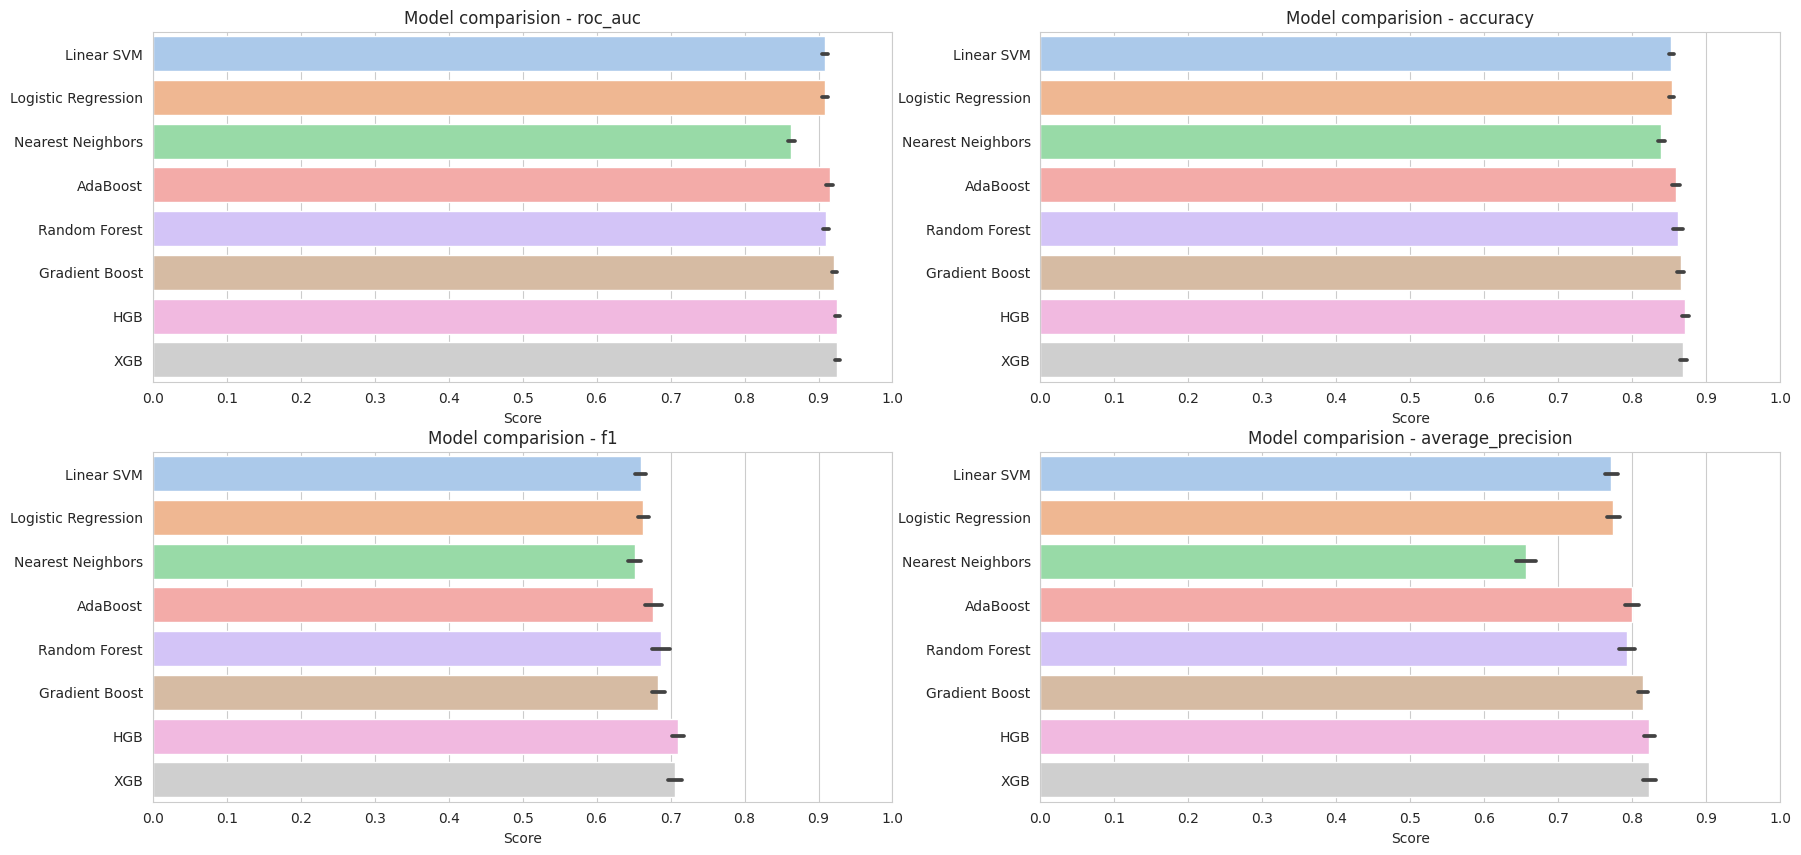

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(21, 10), sharex=False)

for ax, metric in zip(axes.flatten(), scoring):
    sub = models[models['metric'] == metric].copy()
    sns.barplot(
        data=sub,
        x='value', y='model',
        estimator=np.mean, errorbar=('sd'),
        ax = ax, orient='h', palette='pastel'
    )
    
    ax.set_xticks(np.arange(0, 1.01, 0.1))
    ax.set_title(f'Model comparision - {metric}')
    ax.set_xlabel('Score')
    ax.set_ylabel(None)
    
plt.show()

To ensure a fair comparison across all four metrics, we normalize each metric 
to the \[0,1\] range using min–max scaling:

$$
\text{norm\_value}(x) = \frac{x - \min(x)}{\max(x) - \min(x)}
$$

This guarantees that each metric contributes equally, regardless of its absolute scale.  
We then compute the mean of normalized scores across metrics for each model.  
Models with higher values are considered better overall.

In [36]:
def quickscore(models: pd.DataFrame) -> pd.Series:
    models['norm_value'] = models.groupby('metric')['value'].transform(
        lambda x: ((x - x.min()) / (x.max() - x.min()))
    )
    agg_norm = models.groupby('model')['norm_value'].mean().sort_values(ascending=False)
    return agg_norm
quickscore(models)

model
HGB                    0.895606
XGB                    0.869173
Gradient Boost         0.751177
Random Forest          0.669109
AdaBoost               0.649807
Logistic Regression    0.519847
Linear SVM             0.498869
Nearest Neighbors      0.084855
Name: norm_value, dtype: float64

Next steps

1. Build an ensemble of diverse models. Instead of combining several tree-based learners (which tend to produce highly correlated predictions), we select a single representative — HistGradientBoosting (HGB). To increase diversity, we add models from different algorithmic families: Logistic Regression, Linear SVM, and k-Nearest Neighbors. This ensures complementary error structures and maximizes the potential benefit of ensembling.

2. Fine-tune the best individual models. We focus on HGB, which achieved the highest normalized score, and also fine-tune XGB, which is known to be very competitive among gradient boosting methods. These models will serve as strong baselines to compare against the ensemble.

In [37]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

voting_clf = VotingClassifier(
    estimators=[
        ('hgb', HistGradientBoostingClassifier()),
        ('lr', LogisticRegression(random_state=7)),
        ('svc', SVC(kernel='linear', probability=True)),
        ('knn', KNeighborsClassifier())
    ],
    voting='soft'
)
voting_res = cross_validate(voting_clf, X_train_enc, y_train_enc, cv=cv, scoring=scoring, n_jobs=-1)

In [38]:
rows = []
voting_df = pd.DataFrame(voting_res).drop(columns=['fit_time', 'score_time'])
for m in scoring:
    for v in cv_results[f"test_{m}"]:
        rows.append({"model": 'Voting(soft)', "metric": m, "value": v})
voting_df = pd.DataFrame(rows)
models = pd.concat([models, voting_df])
voting_df

,model,metric,value
0,Voting(soft),roc_auc,0.921905
1,Voting(soft),roc_auc,0.923839
2,Voting(soft),roc_auc,0.929814
3,Voting(soft),roc_auc,0.925708
4,Voting(soft),accuracy,0.864097
5,Voting(soft),accuracy,0.867475
6,Voting(soft),accuracy,0.876670
7,Voting(soft),accuracy,0.868530
8,Voting(soft),f1,0.699898
9,Voting(soft),f1,0.703334


In [39]:
quickscore(models)

model
HGB                    0.895606
Voting(soft)           0.869173
XGB                    0.869173
Gradient Boost         0.751177
Random Forest          0.669109
AdaBoost               0.649807
Logistic Regression    0.519847
Linear SVM             0.498869
Nearest Neighbors      0.084855
Name: norm_value, dtype: float64

In [40]:
voting_clf.get_params

<bound method _BaseHeterogeneousEnsemble.get_params of VotingClassifier(estimators=[('hgb', HistGradientBoostingClassifier()),
                             ('lr', LogisticRegression(random_state=7)),
                             ('svc', SVC(kernel='linear', probability=True)),
                             ('knn', KNeighborsClassifier())],
                 voting='soft')>

Our ensemble model achieved 2nd place, which is already a strong result. However, we can explore whether its performance improves when we adjust the voting scheme. In particular, we want to test the scenario where our weakest base learner – *Nearest Neighbors* – is effectively excluded from the ensemble.

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'weights': [
    [1, 1, 1, 1],
    [1, 1, 1, 0],
    [2, 1, 1, 0],
    [2, 1, 1, 1],
    [4, 3, 2, 1]
]}

grid = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=cv,
    n_jobs=-1
)
grid.fit(X_train_enc, y_train_enc)


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=7, shuffle=True),
             estimator=VotingClassifier(estimators=[('hgb',
                                                     HistGradientBoostingClassifier()),
                                                    ('lr',
                                                     LogisticRegression(random_state=7)),
                                                    ('svc',
                                                     SVC(kernel='linear',
                                                         probability=True)),
                                                    ('knn',
                                                     KNeighborsClassifier())],
                                        voting='soft'),
             n_jobs=-1,
             param_grid={'weights': [[1, 1, 1, 1], [1, 1, 1, 0], [2, 1, 1, 0],
                                     [2, 1, 1, 1], [4, 3, 2, 1]]},
             refit='roc_auc',
             scoring=['roc_auc', 'accuracy', 'f1', 'average_precision'])

In [42]:
grid.best_params_

{'weights': [2, 1, 1, 0]}

In [43]:
grid.best_estimator_.score(X_test_enc, y_test_enc)

0.865806847842776

Ok, we got around 86.6% accuracy on our best estimator, let's now try fine-tuning our **XGB** and **HGB** models.

In [44]:
xgb_params = {
    'tree_method' : ['exact', 'approx', 'hist'],
    'max_depth': [4, 6, 8],
    'eta': [0.1, 0.3],
    'subsample': [0.5, 0.75, 1],
    'min_child_weight': [1, 5]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=xgb_params,
    refit='roc-auc',
    cv=cv,
    n_jobs=-1
)
grid_xgb.fit(X_train_enc, y_train_enc)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=7, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.1, 0.3], 'max_depth': [4, 6, 8],
                         'min_child_weight': [1, 5],
                         'subsample': [0.5, 0.75, 1],
                         'tree_method': ['exact', 'approx', 'hist']},
             refit='roc-auc')

In [45]:
print("XGB best params:", grid_xgb.best_params_)
print("XGB accuracy on test:", grid_xgb.best_estimator_.score(X_test_enc, y_test_enc))

XGB best params: {'eta': 0.3, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 1, 'tree_method': 'exact'}
XGB accuracy on test: 0.8734838016275142


In [46]:
hgb_params = {
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [None, 6, 10],
    'min_samples_leaf': [20, 50],
    'l2_regularization': [0.0, 1.0]
}

grid_hgb = GridSearchCV(
    estimator=HistGradientBoostingClassifier(),
    param_grid=hgb_params,
    refit='roc-auc',
    cv=cv,
    n_jobs=-1
)
grid_hgb.fit(X_train_enc, y_train_enc)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=7, shuffle=True),
             estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'l2_regularization': [0.0, 1.0],
                         'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [None, 6, 10],
                         'min_samples_leaf': [20, 50]},
             refit='roc-auc')

In [47]:
print("HGB best params:", grid_hgb.best_params_)
print("HGB accuracy on test:", grid_hgb.best_estimator_.score(X_test_enc, y_test_enc))

HGB best params: {'l2_regularization': 1.0, 'learning_rate': 0.1, 'max_depth': None, 'min_samples_leaf': 50}
HGB accuracy on test: 0.8699524028865346


We successfully fine-tuned both models, with both achieving accuracy roughly 87%.
If you found this notebook useful or insightful, I’d greatly appreciate an upvote — it helps others discover it as well.
And if you have any questions, suggestions, or feedback, feel free to leave a comment — I’ll be glad to discuss and improve further.